# Demo of PlotShapefiles.jl Package

<br>
This Jupyter files demos the use of the PlotShapefiles.jl package. All the data for this demo is contained in the test folders of the package so you should be able to run the demo locally.

<br>
The plotting API is mostly done through three functions:
- **plotshape()** - Draws and colors the shapes.
- **choropleth()** - Draws polygons shaded in proportion to some provided data.
- **google_overlay()** - Overlays a canvas obtained through one of the above functions onto a google static image.

Examples of each of these are described below.

- - -

In [1]:
using PlotShapefiles

## Load some example data

<br>
The typical shapefile has a number of extensions (*.dbf, .sbn, .sbx, .shp, .shx*).  
The only one necessary for plotting with PlotShapefile.jl is the main file (i.e. *.shp*).  
The dBase table *.dbf* can contain useful info for plotting (example shown below).  

The example data can be found here - http://shapelib.maptools.org/ - under the Download section.  
But the data is saved within the package folders so can be loaded using the calls shown below.

### Load the *.shp* files.

In [2]:
mexicopath = joinpath(testdatapath, "shape_eg_data", "mexico")
states = open_shapefile(joinpath(mexicopath, "states.shp"))
cities = open_shapefile(joinpath(mexicopath, "cities.shp"))
roads = open_shapefile(joinpath(mexicopath, "roads.shp"))
lakes = open_shapefile(joinpath(mexicopath, "lakes.shp"))
rivers = open_shapefile(joinpath(mexicopath, "rivers.shp"));

---
Brief diversion:  
Here is a quick example of the plotting before going into more depth on the data and the different plotting options:

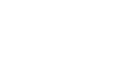

In [3]:
plotshape(states)

- - -

The data type returned by open_shapefile (which uses the Shapefile.jl package) is a "Shapefile.Handle".

In [4]:
typeof(states)

Shapefile.Handle

which has the following fields:

In [5]:
fieldnames(states)

8-element Array{Symbol,1}:
 :code     
 :length   
 :version  
 :shapeType
 :MBR      
 :zrange   
 :mrange   
 :shapes   

Important fields are:
- **shapeType** - Shows what type (e.g. point, polygon, polyline, etc.) the shapefile is
- **MBR** - Minimum Bounding Rectangle (i.e. the coordinates of the rectangle that the shapes fit into)
- **shapes** - An array of the individual shapes

Each is briefly described below.

#### i. shapeType

The ESRI white paper gives a good description of each of the different types of shapefile. It can be found here - https://www.esri.com/library/whitepapers/pdfs/shapefile.pdf

Each of the 13 types of shapefile with values assigned by ESRI are:
- Point (1), PointZ (11), PointM (21)
- Polyline (3), PolylineZ (13), PolylineM (23)
- Polygon (5), PolygonZ (15), PolygonM (25)
- MultiPoint (8), MultiPointZ (18), MultiPointM (28)
- Multipatch (31)

The Z suffix is for file types with a 3rd dimension to the coordinates e.g. altitude or depth for contours (this 3rd dimension is ignored when plotting by PlotShapefile.jl). The M suffix is for file types containing an array of measures for each individual shape. This data can be accessed for plotting - e.g. size of bubble or color for a choropleth (shown below).

The PlotShapefile.jl package currently supports all of the different file types except Multipatch which is a more complicated polygon containing fans and outer and inner rings (like a doughnut).

Lets look at what shapes we are going to plot.

In [6]:
for geog in [states, cities, roads, lakes, rivers]
    println(geog.shapeType)
end

5
1
3
5
3


I.e. we are going to plot polygons, polylines and points.

#### ii. MBR

The MBR (Minimum Bounding Rectangle) is simply a container for the 4 coordinates describing two diagonally opposite corners of the rectangle.

In [7]:
states.MBR

Shapefile.Rect{Float64}(14.550546646118164,-117.12237548828125,32.72080993652344,-86.73500061035156)

#### iii. shapes

The shapes field is an array of individual shapes. Looking inside the "states" file:

In [8]:
typeof(states.shapes)

Array{Shapefile.ESRIShape,1}

In [9]:
states.shapes[1:3]

3-element Array{Shapefile.ESRIShape,1}:
 Polygon(135 Float64 Points)
 Polygon(224 Float64 Points)
 Polygon(72 Float64 Points) 

In [10]:
length(states.shapes)

32

I.e. the array contains 32 polygons. These are the 31 states of Mexico plus Mexico City (a "federal entity"). The *.dbf* file contains the names of the states - viewed in the next step. 

### Load a *.dbf* file

To load the dBase table I'm using the package DBaseReader.jl written by Penn Taylor. This is an unregistered package i.e. needs to be added using the command:
```
Pkg.clone("https://github.com/penntaylor/DBaseReader.jl")
```

I'm also going to use the DataFrames package to convert the table from a Dict into a table.

In [11]:
using DBaseReader, DataFrames

Read in the states data, convert to a DataFrame, and then add the shapes into a column.

Note: You may get some deprecation warnings when reading the *.dbf* file for the first time. You can ignore.

**Note:** The order of the shapes in the shapefile correspond to the records in the dBase table. So don't re-order the rows in the dataframe unless you have already included the shapes.

In [13]:
d = readdbf(joinpath(mexicopath, "states.dbf"))
states_df = convert(DataFrame, d)
states_df[:SHAPES] = states.shapes
head(states_df)

,AREA,CODE,NAME,SHAPES
1,28002.325,MX02,Baja California Norte,Polygon(135 Float64 Points)
2,27898.191,MX03,Baja California Sur,Polygon(224 Float64 Points)
3,10547.762,MX18,Nayarit,Polygon(72 Float64 Points)
4,30736.386,MX14,Jalisco,Polygon(156 Float64 Points)
5,2110.761,MX01,Aguascalientes,Polygon(23 Float64 Points)
6,11715.793,MX11,Guanajuato,Polygon(64 Float64 Points)


The dBase file contained the name of the state and the area (in miles$^2$).

And doing the same for cities:

In [14]:
d = readdbf(joinpath(mexicopath, "cities.dbf"))
cities_df = convert(DataFrame, d)
cities_df[:SHAPES] = cities.shapes
head(cities_df)

,CAPITAL,NAME,POPULATION,STATE_NAME,SHAPES
1,Y,Monterrey,2015000,Nuevo Leon,"Shapefile.Point{Float64}(-100.31708526611328,25.677352905273438)"
2,N,Mazatlan,199830,Sinaloa,"Shapefile.Point{Float64}(-106.41606903076172,23.203832626342773)"
3,Y,Guadalajara,2325000,Jalisco,"Shapefile.Point{Float64}(-103.34379577636719,20.67359161376953)"
4,N,Tampico,435000,Tamaulipas,"Shapefile.Point{Float64}(-97.8426284790039,22.243234634399414)"
5,C,Mexico City,14100000,Distrito Federal,"Shapefile.Point{Float64}(-99.12757110595703,19.427045822143555)"
6,Y,Puebla de Zaragoza,1055000,Puebla,"Shapefile.Point{Float64}(-98.19294738769531,19.04863166809082)"


- - -

## plotshape()

<br> 
There are six different methods.

There are three methods for inputting the main shp::Shapefile.Handle (i.e. the *.shp* file as read in):
1. plotshape(shp; options)
2. plotshape(shp, canvas; options)
3. plotshape(shp, MBR; options)

And three methods for using an array of shapes (e.g. the vector of shapes added to the DataFrames above):
4. plotshape(shparray; options)
5. plotshape(shparray, canvas; options)
6. plotshape(shparray, MBR; options)

Each of the methods will return a Compose.Context type which is essentially a canvas with the shapes drawn onto it.

The two methods with a canvas input is a way to plot onto existing plots - and therefore plot multiple shapefiles onto one canvas.  
The two methods with an MBR input provides a way for the user to provide a specific bounding box.

The options available (all named parameters) are the following:

| Name        | Type           | Default Value  | Note |
| ------------- |:-------------:| -----:|
| convertcoords | function | lonlat_to_webmercator | <div>The two provided options are *lonlat_to_webmercator* (same projection used by Google and OpenStreetMap) and *identity* (use the coordinates as provided).<div>  <div>You can also provide your own projection as a function that takes in two coordinates (x, y) and returns two projected coordinates (x_proj, y_proj).<div> |
| img_width | measure | 12cm | The measure can be any measure type from the Measures.jl package including absolute units (mm, cm, pt, inch), width/height units (w, h) or context units (cx, cy)|
| line_width | measure | 0.05mm | |
| line_color | colortype | "black" | The color can be any color type from the Colors.jl package (e.g. RGB, HSV, etc.) including transparent colors (e.g. RGBA) and named colors (e.g. "red"). |
| fill_color | colortype | *nothing* | The color can also be voided using the *nothing* keyword|
| radius | vector of measures | [0.5cm] | The radius must be vector of measures, but setting radius to a single valued vector applies that value to all points. |

<br>
Let's plot some examples to demo the plotshape function.

### Example 1 - Plot the mexico shapefiles on top of each other.

#### 1.1. Plot the state polygons with the web mercator projection. 
 - Note that web mercator is used by default so in later function calls we will omit this explicit option.

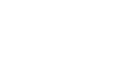

In [15]:
canvas = plotshape(states, convertcoords=lonlat_to_webmercator)

#### 1.2. Plot the city points with yellow outer line, a red fill and a radius of 0.05cm for all points.

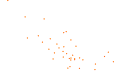

In [16]:
canvas = plotshape(cities, canvas, line_width=0.25mm, line_color="red", fill_color=RGB(1,1,0), radius=[0.05cm])

#### 1.3. Plot the three provided lakes in blue with no border line (i.e. line_width=0mm)

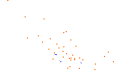

In [17]:
canvas = plotshape(lakes, canvas, line_width=0.0mm, line_color="blue", fill_color="blue")

#### 1.4. Plot the rivers

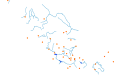

In [18]:
canvas = plotshape(rivers, canvas, line_color=RGB(0.2,0.6,0.8), line_width=0.25mm)

#### 1.5. And finally plot the roads

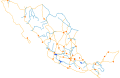

In [19]:
canvas = plotshape(roads, canvas, line_color="orange", line_width=0.2mm)

And let's save that file to disk in SVG fromat:

In [20]:
height_to_width = abs(canvas.units.value.height / canvas.units.value.width)
draw(SVG("mexico_shp1.svg", 15cm, 15cm*height_to_width), canvas)

### Example 2 - Plot city bubbles using the city population for the radius / size of bubble

First, lets normalise the city populations to the range $[0,1]$ and define how big each city radius should be.

In [21]:
pop_min, pop_max = extrema(cities_df[:POPULATION])
pop_range = pop_max - pop_min
normed_pop = (cities_df[:POPULATION] - pop_min) / pop_range
radius_pop = map(x->x*1.0cm, normed_pop);

Then we can plot the two shapes - states and cities.  

**Note:**  
 - Each new shapefile is plotted to the "back" of the canvas i.e. that first shape plotted will be in front. So we need to plot the cities first. But the cities shapefile has a different bounding box to the states so we are explicitly passing the states bounding box (states.MBR) into the function to use.
 - The fill color used for cities circles is a tranparent color (of type RGBA) allowing us to see underneath. 

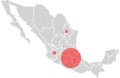

In [22]:
canvas = plotshape(cities_df[:SHAPES], states.MBR,  
                   line_width=0.25mm, line_color=RGBA(1,0,0,0.5), fill_color=RGBA(1,0,0,0.5), radius=radius_pop)
canvas = plotshape(states, canvas,  
                   line_width=0.25mm, line_color="white", fill_color="lightgrey")

And save:

In [23]:
height_to_width = abs(canvas.units.value.height / canvas.units.value.width)
draw(SVG("mexico_shp2.svg", 15cm, 15cm*height_to_width), canvas)

### Example 3 - Plot a selection of states

If we only want to plot a selection of shapes we can filter and use the function method that allows passing in an array of shapes. So - for example - if we wanted to only plot the three states around Mexico City we could do the following:

In [24]:
states_subdf = states_df[findin(states_df[:NAME],["Mexico", "Distrito Federal", "Morelos"]), :]

,AREA,CODE,NAME,SHAPES
1,8291.708,MX15,Mexico,Polygon(62 Float64 Points)
2,512.05,MX09,Distrito Federal,Polygon(13 Float64 Points)
3,1951.676,MX17,Morelos,Polygon(24 Float64 Points)


And then to plot, pass in the subset of shapes. 

**Note:**  
 - The function will determine the minimum bounding box of the provided shapes and use that by default.
 - But you can also pass in a preferred bounding box as shown in the second plot below.

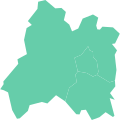

In [25]:
plotshape(states_subdf[:SHAPES], fill_color="MediumAquamarine")

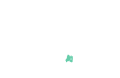

In [26]:
plotshape(states_subdf[:SHAPES], states.MBR, fill_color="MediumAquamarine")

- - -

## choropleth()

<br> 
There are three different methods. Each uses an array of shapes paired with data to use for coloring.

1. choropleth(shparray, color_data, color_map; options)
2. choropleth(shparray, color_data, color_map, canvas; options)
3. choropleth(shparray, color_data, color_map, MBR; options)

The color_data is an array the same length as the shape array (containing the data to be used to map to the colormap.
The color_map is an array of colors that the data will get mapped to for plotting.

As with plotshape() you can let the shparray determine the bounding box or you can input a canvas or an MBR.

The options available are mostly the same as for plotshape without fill_color and radius. And there is an additional option for transforming the color data.

| Name        | Type           | Default Value  | Note |
| ------------- |:-------------:| -----:|
| convertcoords | function | lonlat_to_webmercator | <div>The two provided options are *lonlat_to_webmercator* (same projection used by Google and OpenStreetMap) and *identity* (use the coordinates as provided).<div>  <div>You can also provide your own projection as a function that takes in two coordinates (x, y) and returns two projected coordinates (x_proj, y_proj).<div> |
| img_width | measure | 12cm | The measure can be any measure type from the Measures.jl package including absolute units (mm, cm, pt, inch), width/height units (w, h) or context units (cx, cy)|
| line_width | measure | 0.05mm | |
| line_color | colortype | "black" | The color can be any color type from the Colors.jl package (e.g. RGB, HSV, etc.) including transparent colors (e.g. RGBA) and named colors (e.g. "red"). |
| transform | function | identity | Any transformation function can be used. An example might be wanting to view the data on a log scale. |

<br>

### Example 1 - Plot the mexico states with the size of state as the color variable on a log scale

Using the color to represent size of state is not very interesting but this is just to demo the function.

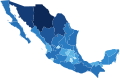

In [27]:
choropleth(states_df[:SHAPES], states_df[:AREA], colormap("blues"), transform=log)

### Example 2 - Plot the same chloropleth and add the population bubbles

This is a demo showing you can merge a choropleth with the outputs of plotshape(). As noted before - be careful which one is plotted first as each new plot is drawn behind the existing.

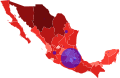

In [28]:
canvas = plotshape(cities_df[:SHAPES], states.MBR, 
                   line_width=0.25mm, line_color=RGBA(0,0,1,0.5), fill_color=RGBA(0,0,1,0.5), radius=radius_pop)
canvas = choropleth(states_df[:SHAPES], canvas, states_df[:AREA], colormap("reds"), transform=log10)

In [29]:
height_to_width = abs(canvas.units.value.height / canvas.units.value.width)
draw(SVG("mexico_ch1.svg", 15cm, 15cm*height_to_width), canvas)

- - -

## google_overlay()

<br>
This function enables the user to take the output of the plots generated above and overlay them onto a Google static image.

There is only one method:
1. google_overlay(canvas, key, zoom; options)

The canvas type is Compose.Context i.e. the output from either plotshape() or chloropleth().  
  
**NB -  
The canvas generated by plotshape() and/or chloropleth() must have used the projection lonlat_to_webmercator. If this projection has not been used then the images will not line up.**  

The key is your Google API key entered as a String. You can [request a key from Google here](https://developers.google.com/maps/documentation/static-maps/get-api-key). It will look something like this: *AKzbSyAKyXIZFTbDZxt6VFLQfFiKpsebVfGFJvv*.  
  
The zoom level is an integer from 0 (the whole world) to 21 (street level zoom).

Here is the [Google static maps documentation](https://developers.google.com/maps/documentation/static-maps/intro) describing their API.

The two options provided for google_overlay() are just pass throughs to the Google static map API.

| Name        | Type           | Default Value  | Note |
| ------------- |:-------------:| -----:|
| scale | Integer | 1 | The options are either 1 or 2. In the free API the maximum size of the image is 640x640 pixels. This is the image maximum size when scale is 1. If scale selected is 2 then the image returned is the same but doubel in pixel size i.e. maximum is 1280x1280. The Google Premium Plan allows larger images - 2048x2048 at scale 1. |
| maptype | String | "roadmap" | The options available are "roadmap", "satellite", "terrain", "hybrid" |

<br>


### Example 1 - Overlaying onto a Google image the choropleth with city bubbles

First we need a transparent colormap for the choropleth so that we can see the underlying Google image. In the cell below the colors are converted from RGB to RGBA with transparency value 0.7.

In [30]:
cmap = colormap("Reds")
tmap = map(x -> RGBA(x, 0.7), cmap);

Then create the same plot with the transparent color map.

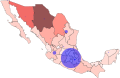

In [31]:
canvas = plotshape(cities_df[:SHAPES], states.MBR, 
                   line_width=0.25mm, line_color=RGBA(0,0,1,0.5), fill_color=RGBA(0,0,1,0.5), radius=radius_pop)
canvas = choropleth(states_df[:SHAPES], canvas, states_df[:AREA], tmap, line_width=0.1mm)

### Satellite image at scale 1:

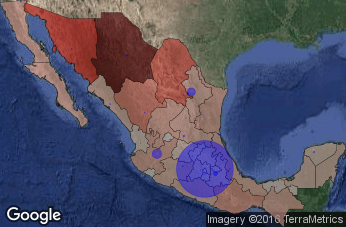

In [32]:
google_overlay(canvas, "EnterYourKeyHere", 4, maptype="satellite")

### Terrain image at scale 2:

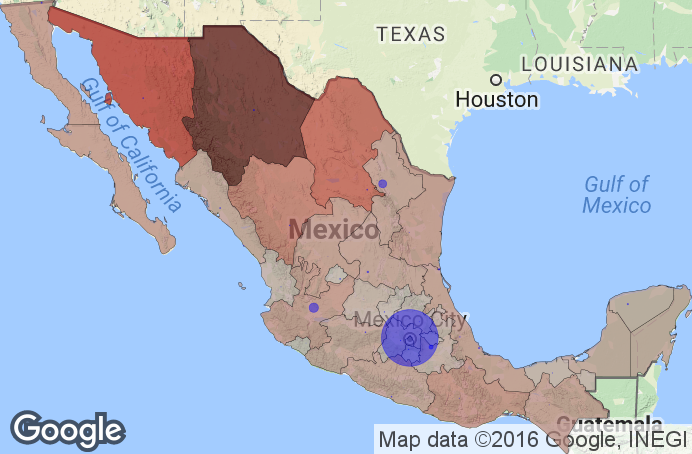

In [33]:
img = google_overlay(canvas, "EnterYourKeyHere", 4, scale=2, maptype="terrain")

The output is of type Image from the Images.jl package.

In [34]:
typeof(img)

Images.Image{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2,Array{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2}}

And the command to save the as a PNG file is:

In [35]:
save("mexico_google.png", img)

- - -